## 21.4 State graphs

As I mentioned in [Section&nbsp;17.1](../17_Graphs_1/17_1_modelling.ipynb#17.1-Modelling-with-graphs),
directed graphs can represent states and transitions between states.
The example I gave was the states of the board during a game of
Noughts and Crosses (also known as Tic-tac-toe).
The transitions between states are the player moves.

This section shows an example of a problem that can be easily solved if
we model it with a state transition graph.

### 21.4.1 Problem

The problem to solve is similar to the one about a
[knight moving on a chessboard](../19_Practice-2/19_5_knight.ipynb#19.5-A-knight-goes-places), but this time
using a rook – a chess piece that moves only horizontally or vertically.
We're given a rectangular board of squares, a start square and an end square.
We want to find the fewest moves for the rook to go
from the start to the end square, with the proviso that moves have
to successively be 1, 2, 3, 1, 2, 3, 1, ... squares long
until the end square is reached.

This means that the first move goes to an adjacent square,
the second move jumps over one square, the third move jumps over two,
the fourth move goes again to an adjacent square, etc.
If there's a path (a sequence of moves) from the start to the end that
stays within the board,
then output the length of the path (the number of moves), otherwise output –1.

The next figure shows a 4×4 board, with a rook symbol on the start square and
an E marking the end square. For this input, the output should be four.
A path of length four goes first one square right, then two squares right,
then three squares down and finally one square left.

<p id="fig-21.4.1"></p>

*[Figure 21.4.1](../33_Figures/Figures_21_4.ipynb#Figure-21.4.1)*

![Image 21_4_jumps.png](21_4_jumps.png)

A path that first goes two squares to the right and then three down is shorter,
but it's not a valid path because it doesn't start with a move of one square.

To check your understanding of the movement, find another shortest valid path
from the start to the end, also in four moves.

___

Move one square down, then two squares down, then three to the right and
finally one to the left.

As usual, I first construct some test cases.
The inputs and output are exactly as for the knight moves problem:
three input pairs of integers indicating the size of the board and
the coordinates of the start and end squares, and
one output integer indicating the shortest path length.

In [1]:
from algoesup import check_tests

rook_moves_tests = [
    # case,             size,   start,  end,    moves
    ('1x1 board',       (1, 1), (0, 0), (0, 0),     0),
    ('1 row, 2 cols',   (1, 2), (0, 0), (0, 1),     1),
    ('start = end',     (3, 3), (1, 1), (1, 1),     0),
    ('figure example',  (4, 4), (0, 0), (3, 2),     4),
    ('2 away',          (4, 4), (0, 0), (0, 2),    -1)
]

check_tests(rook_moves_tests, [tuple, tuple, tuple, int])

OK: the test table passed the automatic checks.


<div class="alert alert-info">
<strong>Info:</strong> This is a simplification of problem
<a href="http://ctp.di.fct.unl.pt/~amd/cpn/2004miup/oficial/problems/I/I.html">Eternal Truths</a>
from the 2004 Portuguese University Programming Contest.
</div>

### 21.4.2 Graph

The problem asks for the fewest moves. As for the knight moving on a chessboard,
this seems to be a shortest path problem on an undirected graph,
with one node per square.
However, the distance of the move changes in each step, so
the neighbours of each square are constantly changing.
It seems we need three graphs instead of one.

Here they are for the example board above.
In the left-hand graph, the edges connect the adjacent squares.
In the middle graph, the edges connect nodes that are two squares away.
In the right-hand graph, the edges connect nodes that are three squares away.

<p id="fig-21.4.2"></p>

*[Figure 21.4.2](../33_Figures/Figures_21_4.ipynb#Figure-21.4.2)*

![Image 21_4_undirected.png](21_4_undirected.png)

The algorithm would be a modified breadth-first search
that is constantly switching between graphs, because
the first, fourth, seventh, ... moves are done on the left-hand graph,
the second, fifth, eighth, ... moves are done on the middle graph,
the third, sixth, ninth, ... moves are done on the right-hand graph.
This sounds too complicated and error-prone to me.

We need an approach that uses a single, unchanging graph, because
all our graph algorithms work on such graphs,
not on graphs where the edges are changing as the algorithm progresses.

The solution is to define a graph that represents the possible states of
the rook. As breadth-first search explores the paths from the start node,
it needs to know which square the rook is on and what move it can do next.
The state of the rook is its current position and the distance of the next move.

For each square S we need three nodes (S, 1), (S, 2) and (S, 3) that represent
the three possible states for when the rook is in that square:
it can next move by one, two or three squares.

The graph has one edge (A, 1) ⟶ (B, 2) for each
square B that is adjacent to square A.
The edges state that the rook can move from any square to any adjacent square
if the next move is by one square. Once it does the move, the rook is in a state
where it next moves by two squares. Likewise there are edges

- (A, 2) ⟶ (B, 3) for each position B that is two squares away from A
- (A, 3) ⟶ (B, 1) for each position B that is three squares away from A.

Here's the state transition graph for a 1×4 board: a single row of four squares.

<p id="fig-21.4.3"></p>

*[Figure 21.4.3](../33_Figures/Figures_21_4.ipynb#Figure-21.4.3)*

![Image 21_4_states.png](21_4_states.png)

The layout of the edges shows when the rook can move left or right.
The first move, from (A, 1) to (B, 2),
goes to the square left or right of A, when possible.
The second move, from (A, 2) to (B, 3),
goes left or right by two squares when possible.
Finally, the third move, from (A, 3) to (B, 1), is only possible
from the left-most to the right-most square and vice versa.

Having constructed this graph, we apply BFS to find the shortest path from
(*start*, 1) to (*end*, *move*) where *move* can be any value.
Once we reach the end square, we don't really care what the next move should be.

### 21.4.3 Code

First, I construct the state transition graph.

In [2]:
%run -i ../m269_digraph


def state_transitions(size: tuple) -> DiGraph:
    """Return the state transition graph for a board of the given size.

    Preconditions: size is a pair of positive integers, the number of rows and columns
    """
    rows = size[0]
    columns = size[1]
    states = DiGraph()
    # add nodes (S, 1), (S, 2), (S, 3) for every square S
    for row in range(rows):
        for column in range(columns):
            for move in (1, 2, 3):
                states.add_node(((row, column), move))
    # add edges
    for state in states.nodes():
        position = state[0]
        distance = state[1]

        row = position[0]
        column = position[1]

        next_distance = distance % 3 + 1  # 1 -> 2 -> 3 -> 1 -> ...

        # generate the 4 possible moves: up, left, down, right
        for move in (-distance, distance):
            # do vertical move if it stays within board
            if 0 <= row + move < rows:
                next_state = ((row + move, column), next_distance)
                states.add_edge(state, next_state)
            # do horizontal move if it stays within board
            if 0 <= column + move < columns:
                next_state = ((row, column + move), next_distance)
                states.add_edge(state, next_state)

    return states

Before moving on, I test this function with a small 1×3 board.
Remember that the graph layout is semi-random, so you may have to
run the next cell a few times to get a more understandable drawing.

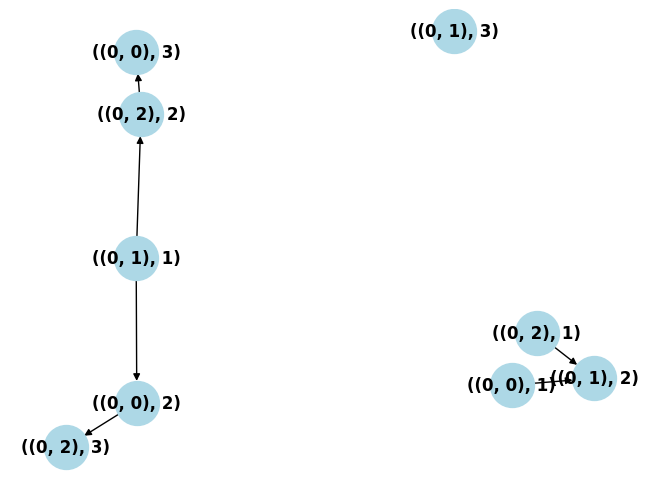

In [3]:
state_transitions((1, 3)).draw()  # single row, three columns

You should be able to see, among other edges,
((0, 1), 1) ⟶ ((0, 0), 2) ⟶ ((0, 2), 3):
the rook moves one square left from (0, 1) to (0, 0) and then
two squares right to (0, 2).
Moving next by three squares would put the rook outside the board.

Next, I copy [the code](../32_Answers/Answers_19_5_04.ipynb) for
the knight moves problem and modify it for this problem.
I'll explain the changes after the code.

In [4]:
%run -i ../m269_queue


def rook_moves(size: tuple, start: tuple, end: tuple) -> int:
    """Return the least number of 1, 2, 3, 1, ... rook moves from start to end.

    Return -1 if end is not reachable from start.

    Preconditions:
    - size is a pair (rows, columns) with rows > 0 and columns > 0
    - start and end are pairs (r, c) with 0 <= r < rows and 0 <= c < columns
    """
    if end == start:
        return 0

    graph = state_transitions(size)  # change 1

    initial_state = (start, 1)  # change 2
    visited = {initial_state}  # change 2
    unprocessed = Queue()
    for neighbour in graph.out_neighbours(initial_state):  # change 2
        unprocessed.enqueue((neighbour, 1))  # change 4
    while unprocessed.size() > 0:
        to_visit = unprocessed.dequeue()
        current = to_visit[0]
        length = to_visit[1]
        if current[0] == end:  # change 3
            return length
        elif current not in visited:
            visited.add(current)
            for neighbour in graph.out_neighbours(current):
                unprocessed.enqueue((neighbour, length + 1))  # change 4
    return -1

The changes were as follows, besides the trivial modifications to the header and docstring.

1. Replace the code that creates the graph for the knight's moves with a call to `state_transitions`.
2. The initial node is `(start, 1)` instead of `start` because nodes now represent states, not squares.
3. For the same reason, extract the square from the `current` node before comparing it to the `end` square.
4. Further simplify the BFS algorithm, which I could have already done
   for the knight moves problem. Instead of adding to the queue edge (A, B)
   with the length of the path to B, I just add B and the length, because
   the shortest path is not asked for, only its length.

Finally, let's run the code on the test table created at the start.

In [5]:
from algoesup import test

test(rook_moves, rook_moves_tests)

Testing rook_moves...
Tests finished: 5 passed (100%), 0 failed.


The moral of this and similar problems is:

<div class="alert alert-warning">
<strong>Note:</strong> Instead of inventing a new graph algorithm, model the problem
with a graph that allows you to apply or adapt a standard graph algorithm.
</div>

Nodes can represent anything, including places, tasks, events, states.
Edges may be weighted and directed. This gives graphs a great modelling power.
Once we represent the input as a graph, we can often solve the problem with
a standard graph algorithm or some small adaptation of it, as done above,
because many graph problems fall into one of a small number of categories: find
a shortest path, a minimum spanning tree, a topological sort or
the graph's components.

### 21.4.4 Complexity

The complexity of this kind of approach
(transform the input into a graph and apply a graph algorithm) is
Θ(*n* + *e*) to construct the graph plus
whatever the complexity of the graph algorithm is.
For this problem, the algorithm used is BFS so the overall complexity is
Θ(*n* + *e*) + Θ(*n* + *e*) = Θ(*n* + *e*).

However, the complexity must be stated in terms of the input,
not of the constructed graph. We must determine the number of nodes and edges
in terms of the input variables, and restate the complexity in those terms.

#### Exercise 21.4.1

The main input variable is the size of the board: the number of rows *r* and
the number of columns *c*.

1. How many nodes does the state transition graph have, in terms of *r* and *c*?
   In other words, give an expression for *n*, using *r* and *c*.
1. How many edges does the state transition graph have at most?
   State *e* as an expression in terms of *r* and *c*.
1. Using the previous expressions, give the complexity Θ(*n* + *e*)
   in terms of *r* and *c*.

_Write your answer here._

[Hint](../31_Hints/Hints_21_4_01.ipynb)
[Answer](../32_Answers/Answers_21_4_01.ipynb)

⟵ [Previous section](21_3_topological.ipynb) | [Up](21-introduction.ipynb) | [Next section](21_5_practice.ipynb) ⟶